In [1]:
import sklearn
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/titanic_data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The *Cabin* column has a lot of missing data. The value imputation would have a big error if we impute the data.

In [3]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [4]:
df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

A small remark when talking about tickets and their importance in the ml:
* The big thing are the prefixes like 'A/5', 'PC', 'W./C' because they mostly mean the company that issued the ticked or the class or both. The tickets without prefixes are just for identification.
* Since the tickets mainly mean the class of the person, it would be ok to drop the column, since we have another column with the people classes - *Pclass*

In [5]:
df = df.drop(['Name','Ticket','PassengerId','Cabin'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [6]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
from sklearn.preprocessing import OneHotEncoder
df.dropna(subset=['Embarked'], inplace=True)

encoder = OneHotEncoder(sparse=False)  

columns_to_encode = ['Sex','Embarked']

encoded_data = encoder.fit_transform(df[columns_to_encode])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

df = df.drop(columns=columns_to_encode)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


Since there are only two missing values in *Embarked* i just used drop nan and then used OneHotEncoder since there are only 3 or 2 classes in those columns

<Axes: >

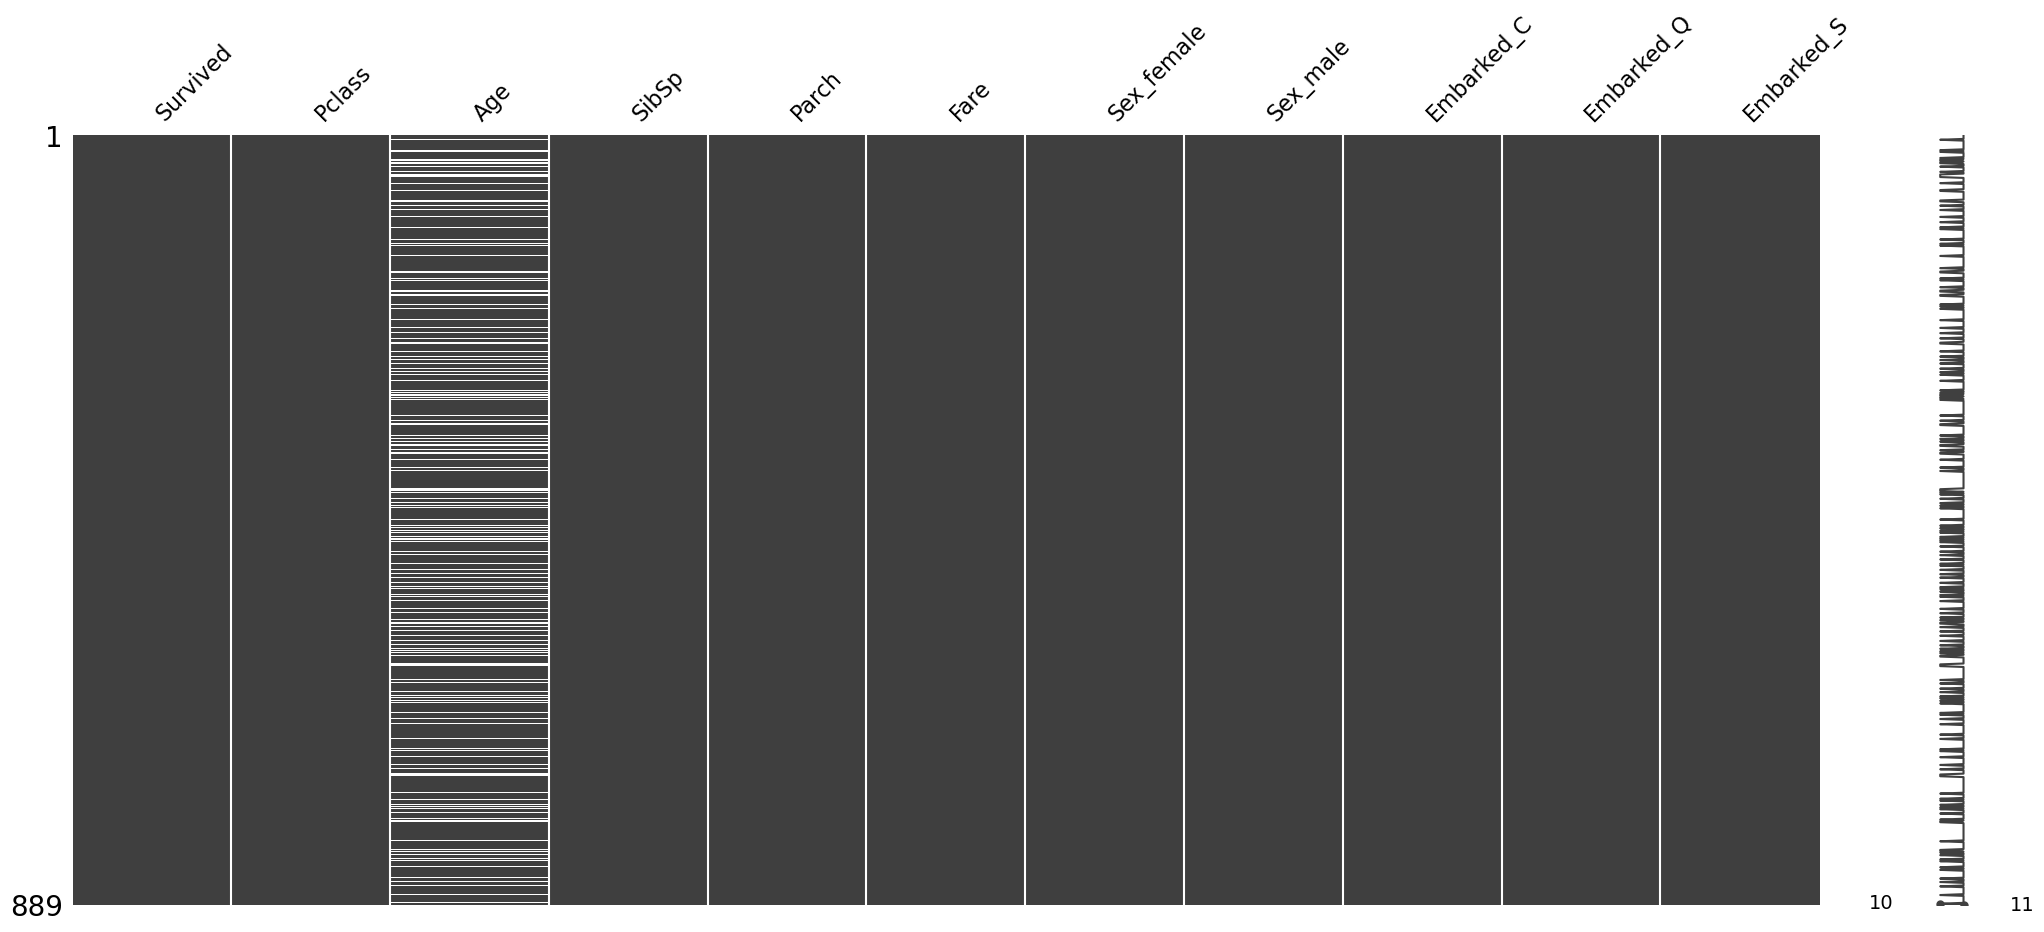

In [9]:
import missingno as msno
msno.matrix(df)

Thus, because "Survived" column is our target, we will drop the NaN rows. "Cabin" column is lacking a lot of data, thus it would be worthless to use MICE or Interpolation. It is more useful to just drop the NaN values. For the "Age" column, we will use MICE though.

## Missing Values Imputation

<Axes: >

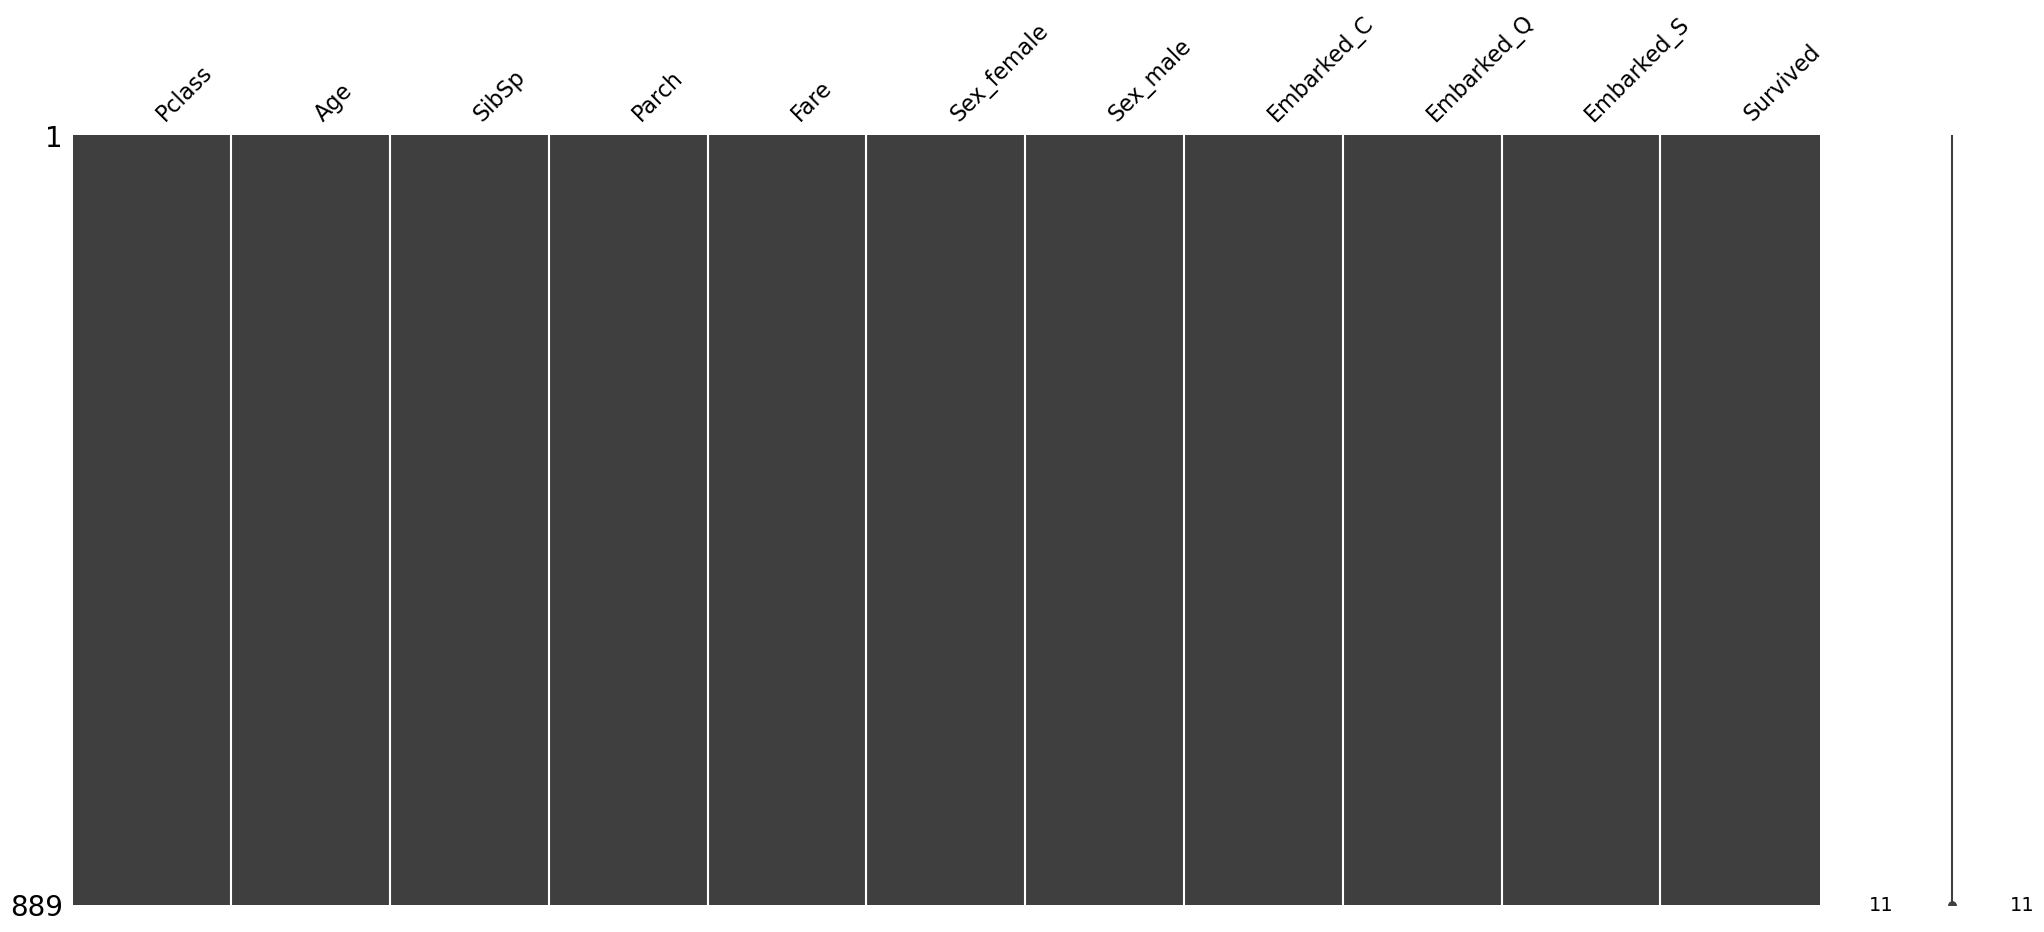

In [11]:
from reparo import MICE
from sklearn.model_selection import train_test_split
imputer = MICE()
X = df.drop('Survived', axis=1)  
y = df['Survived']
imputed_X = X.copy()
imputer.apply(imputed_X, imputed_X.columns)
df = pd.concat([imputed_X, y], axis=1)
msno.matrix(df)

## Feature Scaling

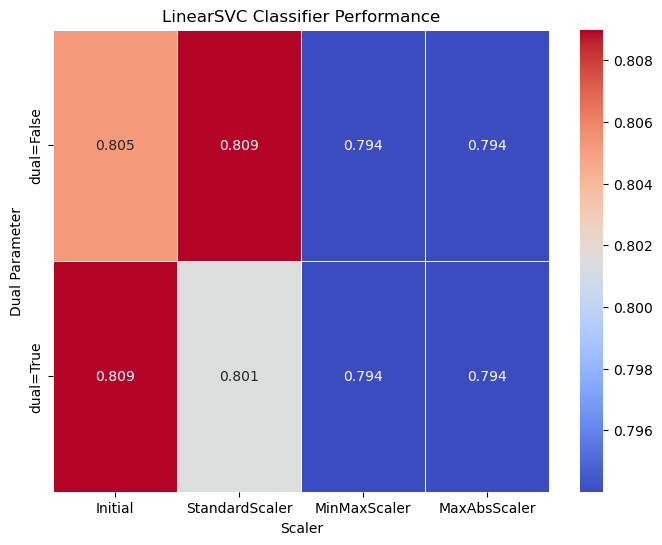

In [12]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(imputed_X, y, test_size=0.3, random_state=42)
scalers = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
dual_params = [False, True]

scores_data = []
for dual in dual_params:
    scores = {}
    for scaler in scalers:
        X_train_scaled = scaler.fit_transform(X_train) if scaler is not None else X_train
        X_test_scaled = scaler.transform(X_test) if scaler is not None else X_test
        col = scaler.__class__.__name__ if scaler is not None else 'Initial'

        clf = LinearSVC(random_state=42, dual=dual)
        clf.fit(X_train_scaled, y_train)

        scores[col] = clf.score(X_test_scaled, y_test)
    scores_data.append(scores)

table = pd.DataFrame(scores_data, index=['dual=False', 'dual=True'])


plt.figure(figsize=(8, 6))
sns.heatmap(table, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title('LinearSVC Classifier Performance')
plt.xlabel('Scaler')
plt.ylabel('Dual Parameter')
plt.show()


As seen, the best performance and accuracy is realized by Standard Scaler, however LinearSVC is better when the dataset is in the initial state. This might be strange, however scaling a dataset can be a major factor on the long run.

## Feature selection

<Axes: >

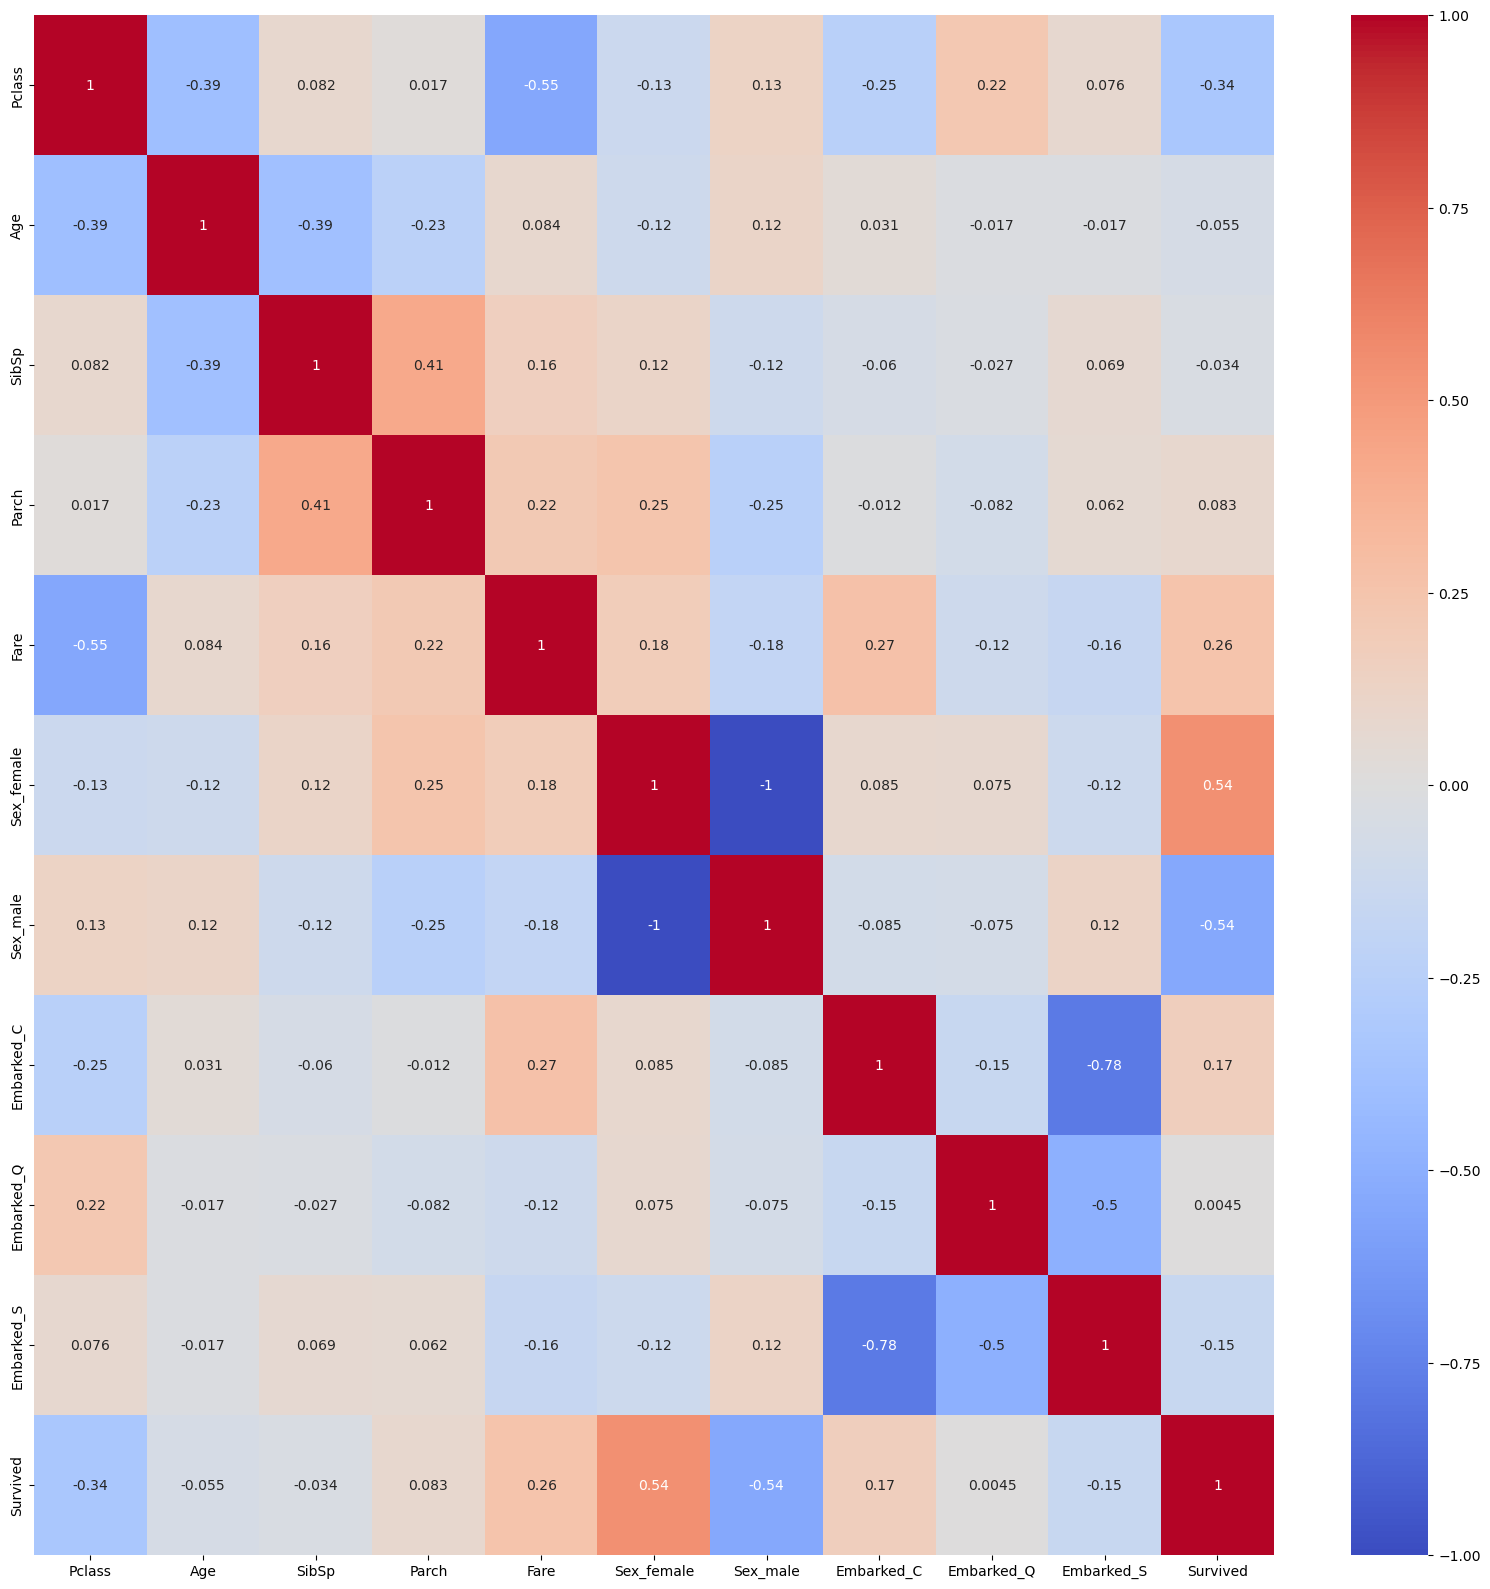

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df.corr()
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),annot = True, cmap='coolwarm')

In [14]:
print(df.corr()["Survived"].abs().sort_values(ascending=False))

Survived      1.000000
Sex_male      0.541585
Sex_female    0.541585
Pclass        0.335549
Fare          0.255290
Embarked_C    0.169966
Embarked_S    0.151777
Parch         0.083151
Age           0.055385
SibSp         0.034040
Embarked_Q    0.004536
Name: Survived, dtype: float64


## Decision Boundaries

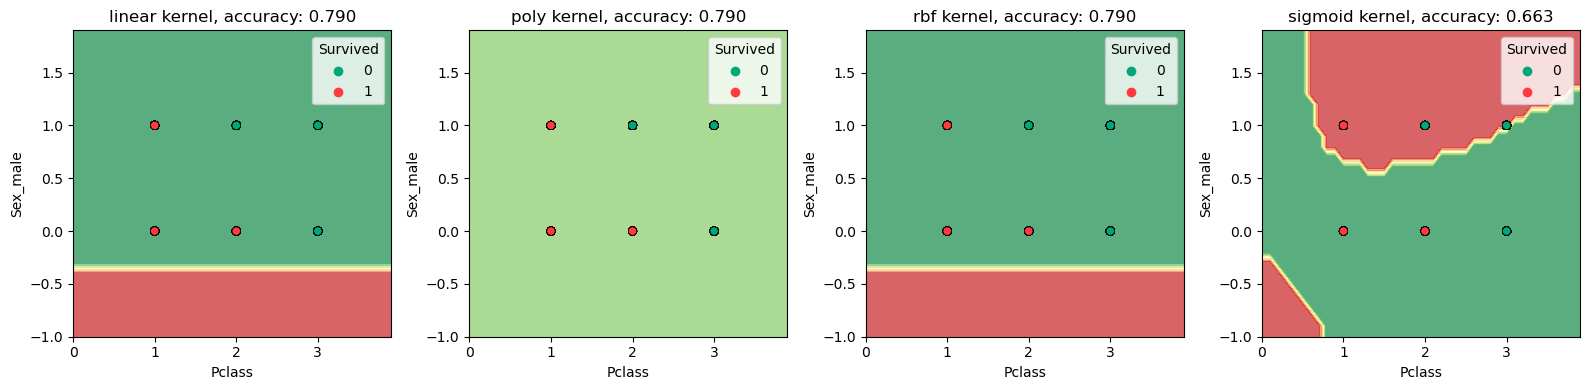

In [15]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

def decision_boundaries(df, features):
    kernels = ['linear', 'poly',  'rbf', 'sigmoid']
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    std = StandardScaler()
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)

    min1, max1 = X[features[0]].min() - 1, X[features[0]].max() + 1
    min2, max2 = X[features[1]].min() - 1, X[features[1]].max() + 1

    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)

    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    sns.set_palette(['#00A878', '#FF3B3F'])

    for i, kernel in enumerate(kernels):
        model = SVC(kernel=kernel, random_state=42)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(grid)
        zz = y_pred.reshape(xx.shape)
        score = model.score(X_test_scaled, y_test)

        ax[i].contourf(xx, yy, zz, cmap='RdYlGn_r', alpha=0.7)
        ax[i].set_title(f'{kernel} kernel, accuracy: {score:.3f}')
        sns.scatterplot(x=features[0], y=features[1], hue=y, data=df, edgecolor='k', ax=ax[i])

    plt.tight_layout()
    plt.show()
    
features = ['Pclass','Sex_male']
decision_boundaries(df,features)

Taking *Pclass* and *Sex_male* as the main features for the decision boundaries because the class column is related to the location of the people in Titanic ( first class is the upper part, second class - middle and third class - lower part). As for the sex column is choosen aleatory (both sex columns have the same correlation) and because the gender might be important in this kind of situations (males are stronger mostly and can evade more easy, females in the most cases are lightweight, thus they have a bigger chance to survive on water).
<br>
<br>
**Observations:**
* The best accuracy is had by the linear, poly and rbf kernel. However, I have some doubts about the linear kernel because it has a big accuracy due to the features that I've selected.
* I think it will be a good practice to experiment, and use other features (with a big correlation) , and see how kernels will behave

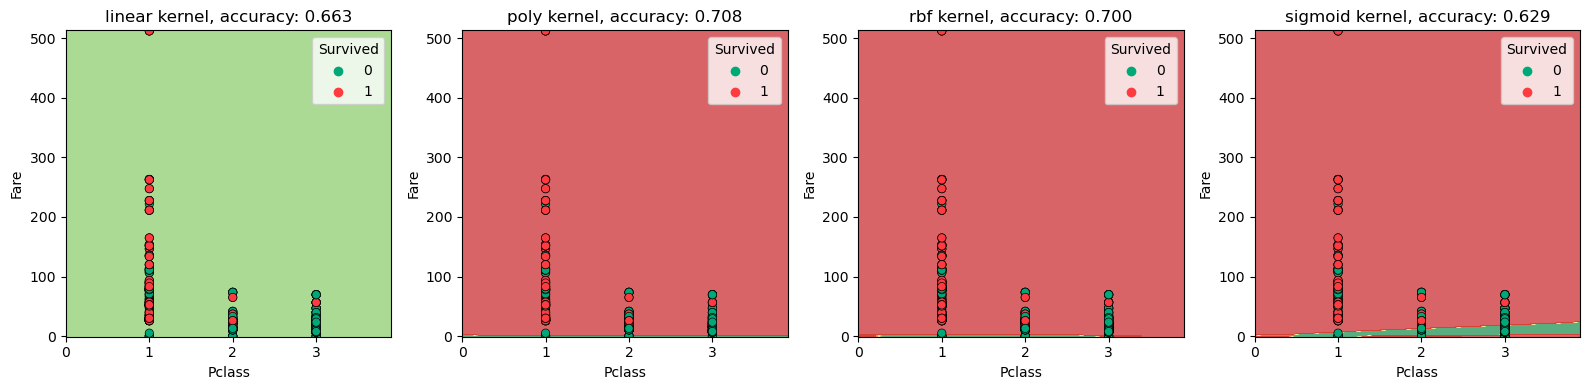

In [16]:
features = ['Pclass','Fare']
decision_boundaries(df,features)

Now, we've got the big picture: 
* poly and rbf kernels are stable and maintaining the biggest accuracy, while linear kernel is situational.
* Now let's train two models of SVM (poly and rbf), to compare their results
* Got depressive seeing the sigmoid kernel results

# Model Training. Comparison. Conclusions

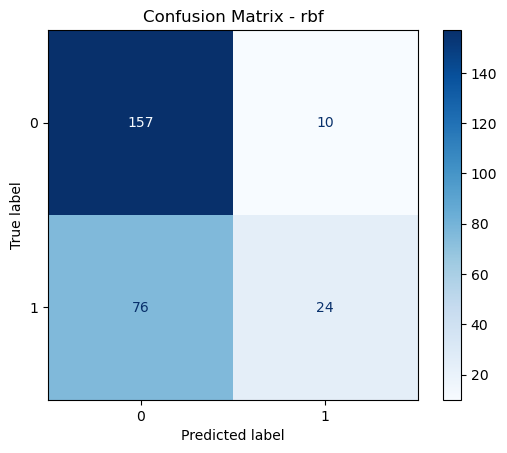

F1 Score for rbf: 0.625153166750517


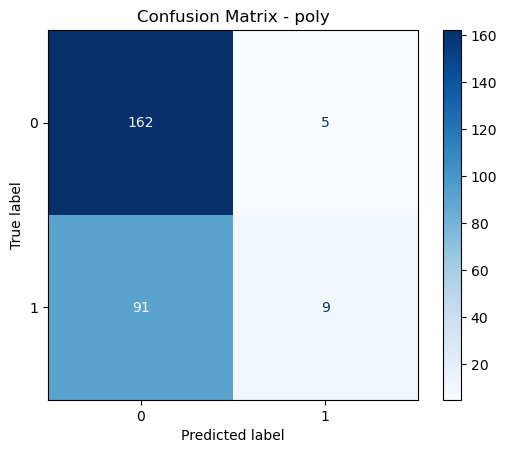

F1 Score for poly: 0.5416406183999324


In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import f1_score

def train_svm_and_evaluate(df, kernel_type):
    X = df.drop('Survived', axis=1)  
    y = df['Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    svm_classifier = SVC(kernel=kernel_type)

    svm_classifier.fit(X_train, y_train)

    y_pred = svm_classifier.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted') 
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f"Confusion Matrix - {kernel_type}")
    plt.show()
    print(f"F1 Score for {kernel_type}:", f1)
    
train_svm_and_evaluate(df,'rbf')
train_svm_and_evaluate(df,'poly')

Okay, pretty bad results. But if I try...

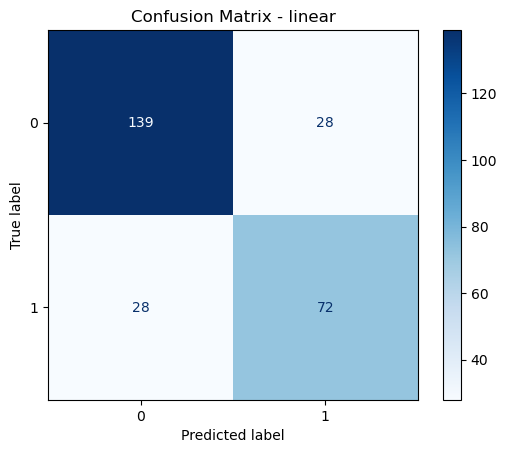

F1 Score for linear: 0.7902621722846442


In [18]:
train_svm_and_evaluate(df,'linear')

**Observations:**
* Linear kernel has proven itself as a situational kernel, and since the dataset is made mostly out of categorical and class data, the accuracy of it became the biggest.

## Using PCA

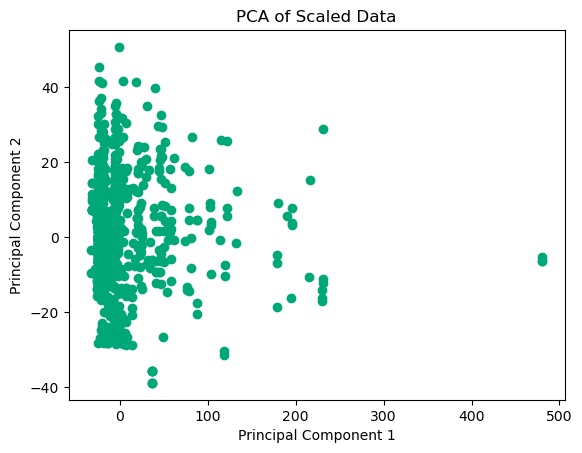

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X = df.drop('Survived', axis=1)  
y = df['Survived']

X_pca = pca.fit_transform(X)

X_pca = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])

plt.scatter(X_pca['Principal Component 1'], X_pca['Principal Component 2'])
plt.title('PCA of Scaled Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [20]:
df = pd.concat([X_pca, y], axis=1)
df.head()

,Principal Component 1,Principal Component 2,Survived
0,-25.027870,-6.724166,0
1,39.405395,7.696696,1
2,-24.253641,-2.722237,1
3,21.150577,5.152475,1
4,-23.908137,6.273164,0


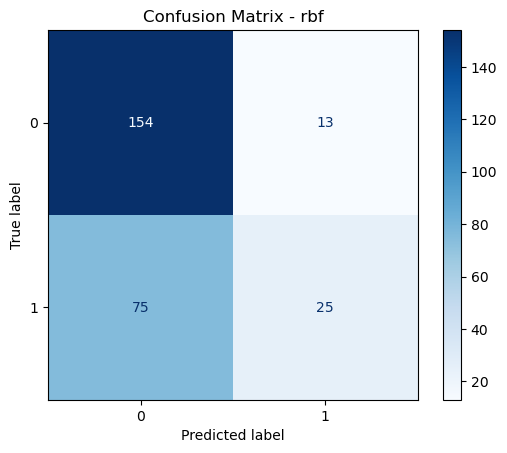

F1 Score for rbf: 0.6221751795762543


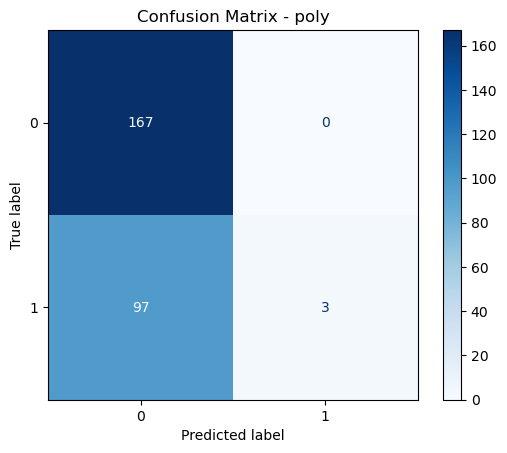

F1 Score for poly: 0.5065189361179947


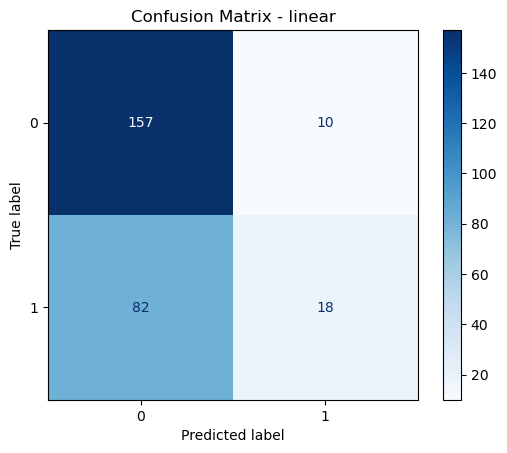

F1 Score for linear: 0.5890735410785779


In [21]:
train_svm_and_evaluate(df,'rbf')
train_svm_and_evaluate(df,'poly')
train_svm_and_evaluate(df,'linear')

**Conclusions**:
* Choosing a kernel is a major thing when training a SVC. Some kernel might depend on the data and how it is structured.
* Using PCA is not always a good maneuver, because sometimes dimensionality reduction might change the accuracy of the model.
* The best kernel before PCA is linear (because of the data and its structure) and after PCA is rbf (it manifested good even when talking about decision boundaries and since now we have a different structure).